## HW 2, Problem 2 -- New algorithms through new regularizers

Problem 1 showed that we can recover the multiplicative weights update through the online optimization framework, by minimizing the combination of a data-driven loss term and a regularizer that encourages randomization (the negative entropy function). However, the negative entropy function is not the *only* function that would encourage randomization. We could always choose other regularizers. What algorithm would be obtain from this? Will it be better or worse than multiplicative weights?

In this problem, we will empirically explore a different choice of regularizer, and compare its performance to multiplicative weights.

We start with some basic imports required for this problem.

In [1]:
#Basic imports
import numpy as np
import matplotlib.pyplot as plt

In Problem 1, you showed that multiplicative weights can be written as the solution to the following optimization problem:
$$\hat{P}_t = {\arg \min}_{p \in [0,1]} \left[f(L_{t-1,1},L_{t-1,0},p) - \frac{1}{\eta} H(p)\right],$$
where $H(p)$ was defined as the binary entropy function.

Now, we will explore a different type of regularizer, i.e. instead consider the update
$$\tilde{P}_t = {\arg \min}_{p \in [0,1]} \left[f(L_{t-1,1},L_{t-1,0},p) + \frac{1}{\eta} R(p)\right],$$
where we now define
$$R(p) := \log\left(\frac{1}{p}\right) + \log\left(\frac{1}{1 - p}\right).$$

This is often called the "log-barrier" regularizer and was actually first proposed by Nemirovski and Yudin.

## Part (a): 

Plot $R(p)$ versus $p$, where $p$ is in the range $[0.01,0.99]$. Where is it minimized? Where is it maximized? Use this plot to argue that minimizing $R(p)$ encourages randomization.

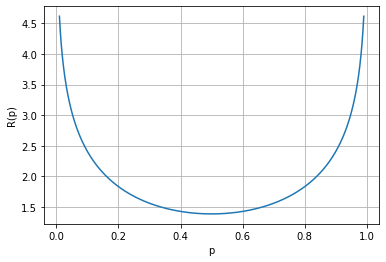

In [2]:
###Answer to part (a):

def R(p):
    
    return np.log(1/p) + np.log(1/(1-p))


pvals = np.linspace(0.01,0.99,1000)
Rvals = np.zeros(1000)
for i in range(1000):
    Rvals[i] = R(pvals[i])
plt.plot(pvals,Rvals)
plt.xlabel("p")
plt.ylabel("R(p)")
plt.grid()
plt.show()

*Answer to part (a)*: You can see from the plot above that $R(p)$ is minimized at $p = 0.5$ and it is maximized at the points $p = 0,1$. Thus, minimizing $R(p)$ encourages randomization.

## Part (b):

The optimization problem defined for the log-barrier regularizer turns out to have a closed form solution, which is given by:
$$\tilde{P}_t := f_2(D_t) := \frac{2}{\eta D_t + \sqrt{\eta^2 D_t^2 + 4} + 2},$$
where $D_t := L_{t-1,1} - L_{t-1,0}$, i.e. the difference in the cumulative losses.

Express the multiplicative weight update at time step $t$ as a different function $\hat{P}_t = f_1(D_t)$. Then, plot both functions $f_1(\cdot)$ and $f_2(\cdot)$ as a function of $d$ ranging between $-10$ and $10$ for the case $\eta = 1$. Which function decreases faster?

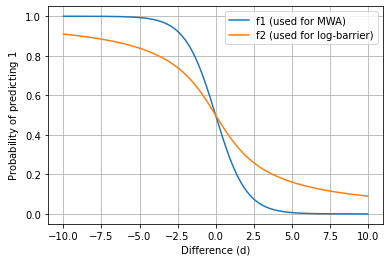

In [3]:
##Answer to part (b):

def f1(d):
    """
    Multiplicative weights update with eta = 1.
    """
    
    return np.exp(-d)/(np.exp(-d) + 1)


def f2(d):
    
    """
    log-barrier update with eta = 1.
    """
    
    return 2/(d + np.sqrt(d**2 + 4) + 2)

dvals = np.linspace(-10,10,1000)
f1vals = f1(dvals)
f2vals = f2(dvals)

plt.plot(dvals,f1vals,label="f1 (used for MWA)")
plt.plot(dvals,f2vals,label="f2 (used for log-barrier)")
plt.xlabel("Difference (d)")
plt.ylabel("Probability of predicting $1$")
plt.legend()
plt.grid()
plt.show()

*Answer to part (b)*: The function $f_1(\cdot)$ clearly decreases faster with $d$.

We will now compare the performance of the two algorithms defined by $\hat{P}_t$ and $\tilde{P}_t$.
First, we define some sequences and some preliminaries.

In [12]:
def GenerateIIDSequence(T, p):
    """
    Code that generates an iid sequence of length T with Bernoulli parameter p.
    """
    
    return np.random.binomial(1, p, T)

def GenerateOnePeriodicSequence(T):
    """
    Code that generates a 1-periodic sequence of length T.
    """
    
    sequence_list = [1,0]*int(T/2)
    return np.array(sequence_list)

## Part (c): 

Implement the multiplicative weights update and the log-barrier update here as a function of the losses $L_{t-1,0},L_{t-1,1}$. In the starter code provided below, the variable "losses" is a numpy array with $2$ entries given by $[L_{t-1,0},L_{t-1,1}]$. Please make the output of your algorithm a numpy array "prob" with $2$ entries, given by $[P_{t,0},P_{t,1}]$.

You are free to refer to (and borrow from) the code provided in the resources "MultiplicativeWeights.ipynb" (note that this was defined for rewards, so will require slight changes).

Hint for log-barrier: recall that we defined $D_t = L_{t-1,1}- L_{t-1,0}$.

In [13]:
def MultiplicativeWeights(losses,eta):
    """
    Implementation of multiplicative weight update, eta is the step size.
    """
    
    d = losses[1] - losses[0]
    prob = np.zeros(2)
    prob[1] = f1(eta*d)
    prob[0] = 1 - prob[1]
    return prob
    
def LogBarrierUpdate(losses,eta):
    """
    Implementation of log barrier update.
    """
    
    d = losses[1] - losses[0]
    prob = np.zeros(2)
    prob[1] = f2(eta*d)
    prob[0] = 1 - prob[1]
    return prob

*Answer to part (c)*: The code above implements the multiplicative weights and log barrier updates from scratch, using the definition of $D_t$ provided above. Any alternative solution (including one that uses the resource "MultiplicativeWeights.ipynb") is allowed as long as the implementation is the same.

## Part (d):

Now, we compare the performance of both algorithms on the two running examples that we have been considering in class.
We set $T = 600$, and consider two types of sequences: 

a) the case where $X_t = 1$ for all $t = 1,\ldots,T$.
b) the case of the $1$-periodic sequence.

For both algorithms, we will set $\eta = 1$ in order to observe a more dramatic visualization in the difference in performance.

Plot the total *loss* of each algorithm (what we defined as $H_t$ in class) versus the number of time steps $t$ on sequences (a) and (b). Please make separate figures for the evaluation of (a) and (b).

You are welcome to directly use the starter code provided below to evaluate the performance of an arbitrary algorithm (parameterized by eta) on an arbitrary binary sequence. This starter code will return a "total loss vector" given by $\begin{bmatrix} H_1 & \ldots H_T \end{bmatrix}$ for plotting convenience.

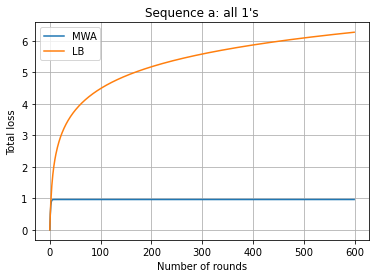

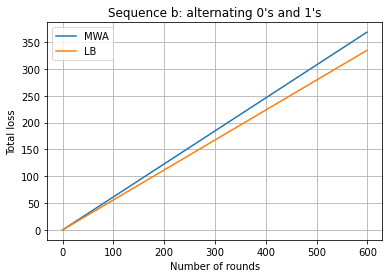

In [27]:
def evaluatePerformance(Alg, sequence, eta):
    """
    Starter code provided to evaluate the performance of an algorithm on a sequence. Here, "Alg" is a function handle.
    You can either use this code directly, or borrow from it to create separate functions to evaluate performance of the two algorithms.
    """
    
    T = len(sequence)
    
    total_loss_alg = 0 #denotes total loss of algorithm at current round
    total_loss_vector_alg = np.zeros(T) #denotes vector of running losses, what will be returned by the function
    total_loss_actual = np.zeros(2) #denotes total loss of each letter (0 or 1) at current round
    for t in range(T):
        total_loss_vector_alg[t] = total_loss_alg
        prob = Alg(total_loss_actual, eta)
        total_loss_alg += prob[0]*sequence[t] + prob[1]*(1 - sequence[t]) #0-1 loss function evaluation.
        total_loss_actual[0] += (sequence[t] == 1)
        total_loss_actual[1] += (sequence[t] == 0)
    
    return total_loss_vector_alg

###Solution starts here
###Specify T and eta, creating sequence (a) and (b), and evaluating performance of both algorithms on these sequences.
T = 600
eta = 1
sequence_a = GenerateIIDSequence(T,1)
sequence_b = GenerateOnePeriodicSequence(T)

total_loss_vector_MWA_a = evaluatePerformance(MultiplicativeWeights, sequence_a, eta)
total_loss_vector_MWA_b = evaluatePerformance(MultiplicativeWeights, sequence_b, eta)
total_loss_vector_LB_a = evaluatePerformance(LogBarrierUpdate, sequence_a, eta)
total_loss_vector_LB_b = evaluatePerformance(LogBarrierUpdate, sequence_b, eta)

###Plot H_t v.s. t for both algorithms on sequences (a) and (b) respectively.
#Plot for sequence (a)
Ts = np.arange(T)
plt.plot(Ts, total_loss_vector_MWA_a,label="MWA")
plt.plot(Ts,total_loss_vector_LB_a,label="LB")
plt.xlabel("Number of rounds")
plt.ylabel("Total loss")
plt.grid()
plt.legend()
plt.title("Sequence a: all 1's")
plt.show()

#Plot for sequence (b)
plt.plot(Ts,total_loss_vector_MWA_b,label="MWA")
plt.plot(Ts,total_loss_vector_LB_b,label="LB")
plt.xlabel("Number of rounds")
plt.ylabel("Total loss")
plt.grid()
plt.legend()
plt.title("Sequence b: alternating 0's and 1's")
plt.show()

*Answer to part (d)*: Any solution that obtains this performance on sequence (a) and sequence (b) (and plots them separately) is acceptable.

## Part (e):

Report the superior algorithm for sequence (a) and sequence (b) respectively.
Based on this report, and your answer to part (b), which algorithm do you think tends to randomize more?

_Answer to part (e):_ MWA is superior on sequence (a) (which discourages randomization), and LB is superior on sequence (b) (which encourages randomization). Based on this, we see that LB tends to randomize more than MWA.